In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from raw_data.get_files_from_kaggle import GettingDataFromKaggle
from feature_data.create_feature_data import CreateFeatureData
from exploratory_data_analysis.analyze_data import AnalyzeData
from modelling.train_models import TrainModel
from model_evaluation.evaluate_models import EvaluateModels


## Getting Data From Kaggle

The necessary username and API address for downloading the data from Kaggle are located in the .env file. 

Since these files are confidential, anyone who repeats the work needs to add their own credentials by creating their own .env file.

In [7]:
getting_data_from_kaggle = GettingDataFromKaggle()
getting_data_from_kaggle.run()

Data file successfully downloaded from Kaggle.
Extracted competitive-data-science-predict-future-sales.zip to ./raw_data


## Preparing Training Data

During the creation process of the train and test variables, the main code was continuously updated by checking the data. 

The parts where the variables were examined have been removed to avoid clutter. Details of all variables will be shared in the next section.

In [8]:
create_feature_data = CreateFeatureData()
sales_df = create_feature_data.getting_data()
display(sales_df.head(2))

monthly_sales = create_feature_data.creating_monthly_data(sales_df)
monthly_sales = create_feature_data.fill_empty_months_where_sale_not_exist(monthly_sales)
display(monthly_sales.head(2))

feature_df = create_feature_data.create_lag_features(monthly_sales)
feature_df = create_feature_data.create_cyclic_features(feature_df)
feature_df = create_feature_data.drop_irrelevant_features(feature_df)
feature_df = create_feature_data.process_features(feature_df)
display(feature_df.head(2))

train_df, test_df = create_feature_data.create_train_and_test_data(feature_df)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id_37
0,02.01.2013,0,59,22154,999.0,1.0,1
1,03.01.2013,0,25,2552,899.0,1.0,0


,date_block_num,month,shop_id,sales_item_price_mean,sales_sum,item_category_id_37_ratio
0,0,1,0,531.262049,5578.0,0.059044
1,0,1,1,511.780252,2947.0,0.036006


,target,sales_sum_lag_1,sales_sum_lag_3,sales_sum_lag_6,sales_sum_lag_12,sales_item_price_mean_lag_1,sales_item_price_mean_lag_3,sales_item_price_mean_lag_6,sales_item_price_mean_lag_12,month_sin,month_cos
0,0.0,0.0,0.0,0.0,6127.0,0.0,0.0,0.0,593.904028,0.500000,0.866025
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.866025,0.500000


## Exploratory Data Analysis


============== Data Types ==============

target                          float64
sales_sum_lag_1                 float64
sales_sum_lag_3                 float64
sales_sum_lag_6                 float64
sales_sum_lag_12                float64
sales_item_price_mean_lag_1     float64
sales_item_price_mean_lag_3     float64
sales_item_price_mean_lag_6     float64
sales_item_price_mean_lag_12    float64
month_sin                       float64
month_cos                       float64
dtype: object

----------------------------------------

----------------------------------------
Shape of the DataFrame: (882, 11)
----------------------------------------

======== Descriptive Statistics ========

                                     mean  min           max
target                        1549.070295 -1.0  14610.000000
sales_sum_lag_1               1579.760771 -1.0  12257.000000
sales_sum_lag_3               1726.852608 -1.0  14610.000000
sales_sum_lag_6               1879.748299 -1.0  14610.000

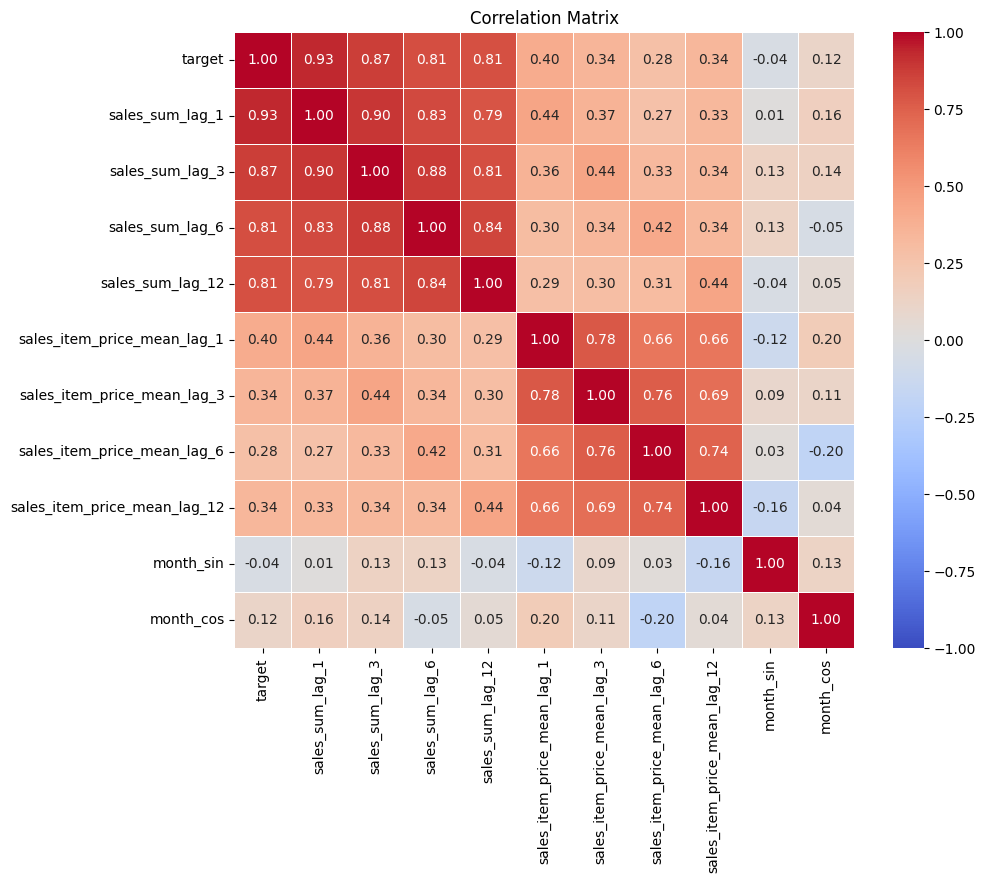

In [10]:
analyze_data = AnalyzeData(train_df)
analyze_data.create_analysis()

The lag variables generated from the sale_sum, item_category and price variables seem to be related to the target variable, and there is a significant correlation between them. 

However, since tree-based models will be used, I will use all the variables without considering the multicollinearity problem.

## Modelling Phase

In [11]:
train_model = TrainModel(train_df)
model_best_param_list, train_x, train_y = train_model.random_search_hyper_parameter_tuning()


Best parameters are found for XGB
Best parameters are {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 1.2, 'gamma': 10, 'colsample_bytree': 0.7}
Best parameters are found for LGB
Best parameters are {'subsample': 0.5, 'num_leaves': 100, 'n_estimators': 1000, 'min_child_samples': 30, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best parameters are found for RF
Best parameters are {'n_estimators': 1500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


The best parameters for each model have been examined, and based on the results, 

the parameter spaces in the config file were updated and rerun. This allowed for a broader exploration of the parameter space.

In [12]:
model_list = train_model.train_model_with_best_params(model_best_param_list)

XGB model trained successfully with the best parameters.
LGB model trained successfully with the best parameters.
RF model trained successfully with the best parameters.


## Evaluating Models

In [13]:
evaluate_models = EvaluateModels(test_df, model_list)
evaluate_models.compare_models_with_test_set()


,Model,MAPE (%),MAE,RMSE
2,RF,13.423399,236.630287,435.725449
1,LGB,16.404327,279.741849,513.584761
0,XGB,38.603948,561.909899,883.887833


After selecting the model that produced the best results, the features for that model were examined. 

If any unexpected behavior in the features is observed, the process of feature creation will be revisited.

In [14]:
best_model = evaluate_models.finding_best_model("RF")

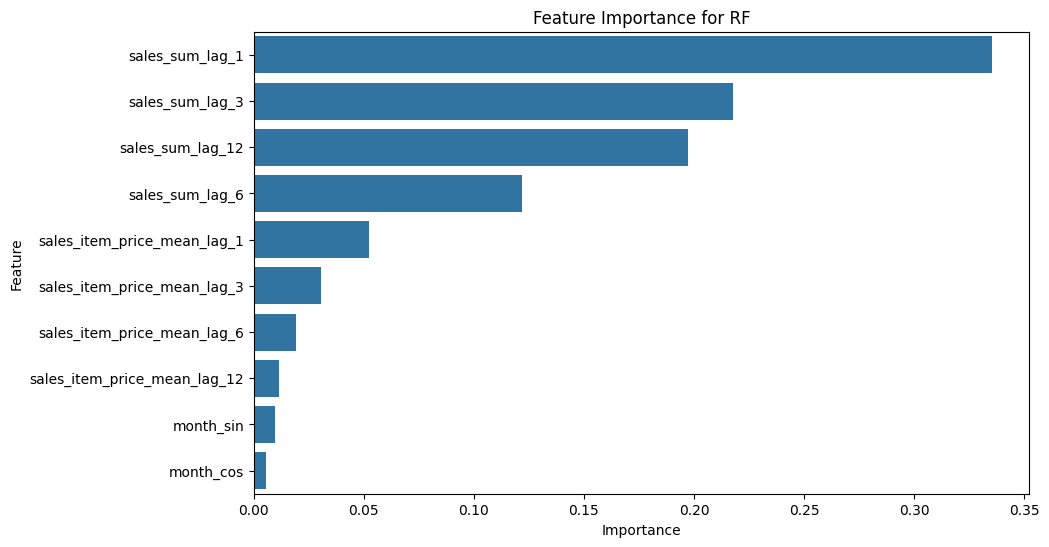

In [18]:
evaluate_models.plot_feature_importance(best_model, "RF")

The importance of the model variables has turned out exactly as expected.

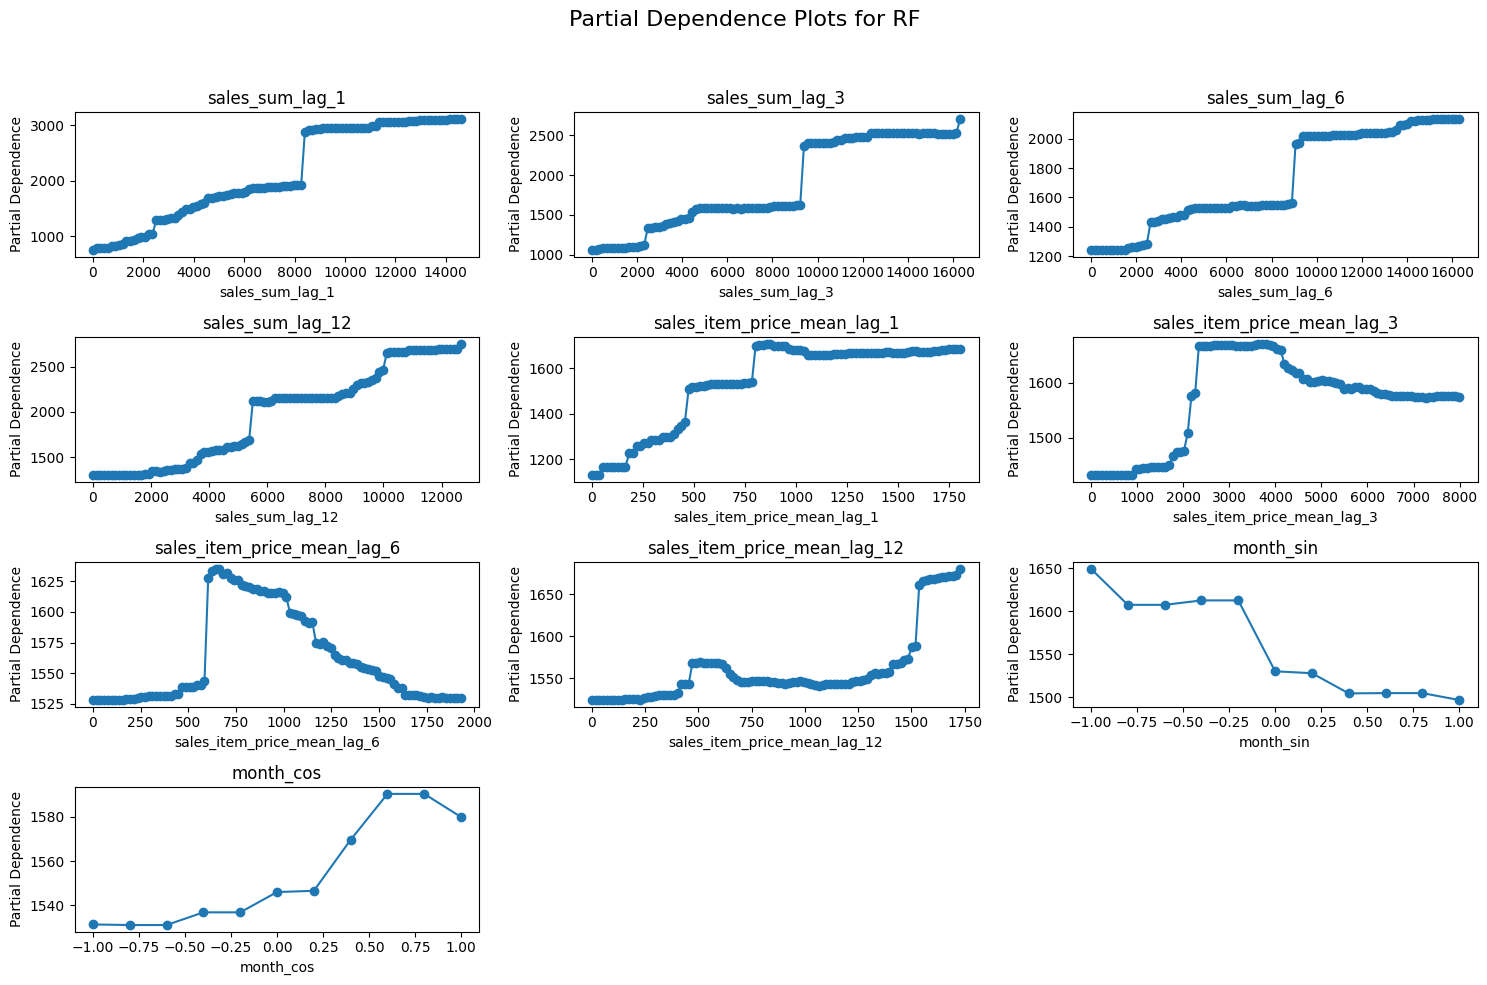

In [19]:
evaluate_models.plot_partial_dependence_plots_for_each_feature(best_model, "RF")

The lag values for sale_sum behaved as expected, 

with half of the item_price lag values showing a positive correlation, while the other two showed a relationship close to a normal distribution. This difference can be explored further during the model development phase. 

The month values have had a complementary effect."